In [6]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as patches

## 数据预处理

### 数据路径和读取

In [2]:
#SSDD数据路径读取
SSDD_train_inshore_img_path = r"/kaggle/input/ship-detect-private/SSDD/SSDD/JPEGImages_train_inshore"
SSDD_train_offshore_img_path = r"/kaggle/input/ship-detect-private/SSDD/SSDD/JPEGImages_train_offshore"
SSDD_test_inshore_img_path = r"/kaggle/input/ship-detect-private/SSDD/SSDD/JPEGImages_test_inshore"
SSDD_test_offshore_img_path = r"/kaggle/input/ship-detect-private/SSDD/SSDD/JPEGImages_test_offshore"
SSDD_train_label_path = r"/kaggle/input/ship-detect-private/SSDD_labels/SSDD_labels/train_labels"
SSDD_test_inshore_label_path = r"/kaggle/input/ship-detect-private/SSDD_labels/SSDD_labels/test_inshore_labels"
SSDD_test_offshore_label_path = r"/kaggle/input/ship-detect-private/SSDD_labels/SSDD_labels/test_offshore_labels"
#SeaShip数据读取
S_img_path = r"/kaggle/input/ship-detect-private/SeaShips(7000)/JPEGImages"
S_label_path = r"/kaggle/input/ship-detect-private/SeaShips_labels/SeaShips_labels/labels"


安装并导入yolo第三方框架

In [6]:

!pip install ultralytics
import ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall

创建符合YOLO第三方库的数据集格式

In [7]:
import os
import yaml
import shutil
from sklearn.model_selection import train_test_split

# 创建数据集配置
def create_dataset_config():
    """创建YOLOv11所需的数据集配置文件"""
    config = {
        'path': '/kaggle/working/combined_dataset',  # 数据集根目录
        'train': 'images/train',  # 训练图像路径
        'val': 'images/val',      # 验证图像路径
        'nc': 1,  # 类别数量（假设都是船舶检测，只有一个类别）
        'names': ['ship']  # 类别名称
    }
    
    # 保存配置文件
    with open('/kaggle/working/combined_dataset.yaml', 'w') as f:
        yaml.dump(config, f)
    
    return config

# 合并数据集
def combine_datasets():
    """合并SSDD和SeaShip数据集"""
    base_dir = '/kaggle/working/combined_dataset'
    os.makedirs(f'{base_dir}/images/train', exist_ok=True)
    os.makedirs(f'{base_dir}/images/val', exist_ok=True)
    os.makedirs(f'{base_dir}/labels/train', exist_ok=True)
    os.makedirs(f'{base_dir}/labels/val', exist_ok=True)
    
    # 收集所有图像和标签路径
    all_images = []
    all_labels = []
    
    # SSDD训练集（inshore + offshore）
    ssdd_train_img_dirs = [SSDD_train_inshore_img_path, SSDD_train_offshore_img_path]
    ssdd_train_label_dir = SSDD_train_label_path
    
    for img_dir in ssdd_train_img_dirs:
        if os.path.exists(img_dir):
            for img_file in os.listdir(img_dir):
                if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    name_without_ext = os.path.splitext(img_file)[0]
                    label_file = os.path.join(ssdd_train_label_dir, name_without_ext + '.txt')
                    
                    if os.path.exists(label_file):
                        all_images.append(os.path.join(img_dir, img_file))
                        all_labels.append(label_file)
    
    # SeaShip数据集
    if os.path.exists(S_img_path) and os.path.exists(S_label_path):
        for img_file in os.listdir(S_img_path):
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                name_without_ext = os.path.splitext(img_file)[0]
                label_file = os.path.join(S_label_path, name_without_ext + '.txt')
                
                if os.path.exists(label_file):
                    all_images.append(os.path.join(S_img_path, img_file))
                    all_labels.append(label_file)
    
    # 划分训练集和验证集（80%训练，20%验证）
    train_images, val_images, train_labels, val_labels = train_test_split(
        all_images, all_labels, test_size=0.2, random_state=42
    )
    
    # 复制文件到统一目录
    def copy_files(file_pairs, image_dest, label_dest):
        for img_path, label_path in file_pairs:
            img_filename = os.path.basename(img_path)
            label_filename = os.path.basename(label_path)
            
            shutil.copy2(img_path, os.path.join(image_dest, img_filename))
            shutil.copy2(label_path, os.path.join(label_dest, label_filename))
    
    copy_files(zip(train_images, train_labels), 
               f'{base_dir}/images/train', f'{base_dir}/labels/train')
    copy_files(zip(val_images, val_labels), 
               f'{base_dir}/images/val', f'{base_dir}/labels/val')
    
    print(f"数据集合并完成！")
    print(f"训练集: {len(train_images)} 张图像")
    print(f"验证集: {len(val_images)} 张图像")
    
    return base_dir

# 执行数据集准备
dataset_config = create_dataset_config()
dataset_path = combine_datasets()

数据集合并完成！
训练集: 6342 张图像
验证集: 1586 张图像


## 开始baseline的训练

In [1]:
from ultralytics import YOLO
import os

def setup_yolo_training():
    """设置YOLOv11训练环境"""
    # 创建模型训练脚本
    model = YOLO('yolo11n.pt')  # 使用预训练的YOLOv11n模型:cite[10]
    
    # 训练参数配置
    training_config = {
        'data': '/kaggle/working/combined_dataset.yaml',
        'epochs': 100,
        'batch': 16,  # 根据GPU显存调整
        'imgsz': 640,
        'device': 0,  # 使用GPU
        'workers': 2,
        'patience': 10,  # 早停耐心值
        'save': True,
        'exist_ok': True,  # 覆盖现有实验
        'pretrained': True,
        'optimizer': 'auto',
        'lr0': 0.01,  # 初始学习率
        'cos_lr': True,  # 使用余弦学习率调度
    }
    
    return model, training_config

def train_yolov11():
    """训练YOLOv11模型"""
    print("开始YOLOv11模型训练...")
    
    model, config = setup_yolo_training()
    
    # 开始训练:cite[4]:cite[10]
    results = model.train(
        data=config['data'],
        epochs=config['epochs'],
        batch=config['batch'],
        imgsz=config['imgsz'],
        device=config['device'],
        workers=config['workers'],
        patience=config['patience'],
        save=config['save'],
        exist_ok=config['exist_ok'],
        pretrained=config['pretrained'],
        optimizer=config['optimizer'],
        lr0=config['lr0'],
        cos_lr=config['cos_lr']
    )
    
    return results, model

# 执行训练
try:
    results, trained_model = train_yolov11()
    print("训练完成！")
except Exception as e:
    print(f"训练过程中出现错误: {e}")

开始YOLOv11模型训练...
Ultralytics 8.3.203 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/kaggle/working/combined_dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, pe

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        278        295       0.99      0.997      0.995      0.841
Speed: 0.1ms preprocess, 1.4ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to /kaggle/working/runs/detect/train
训练完成！


## 结果可视化

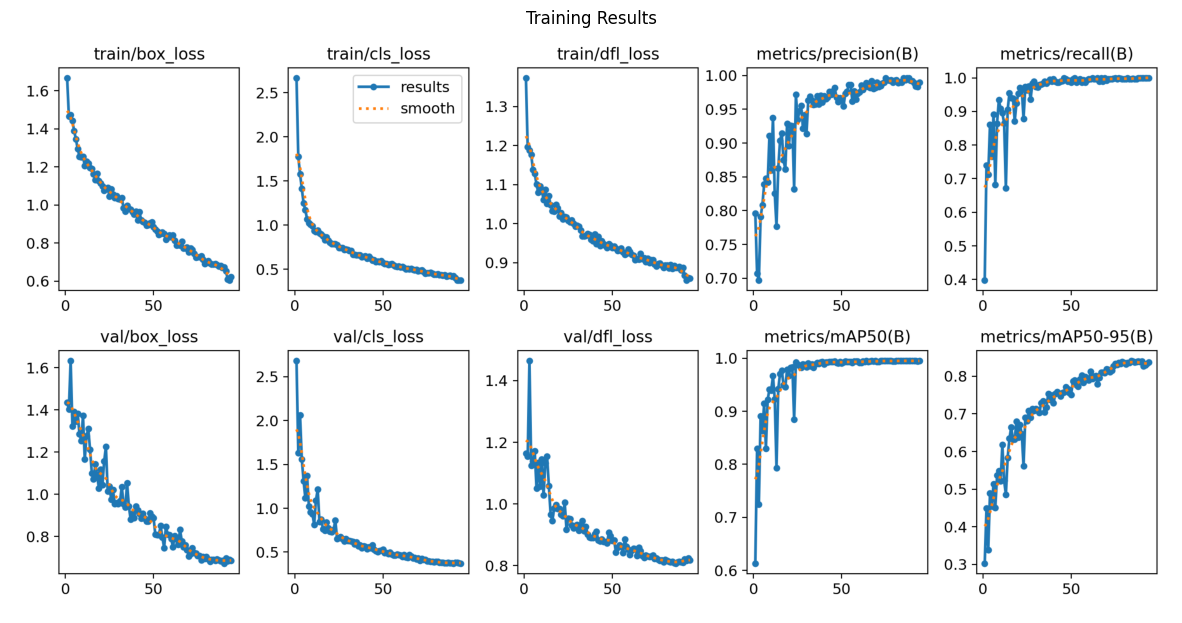

Ultralytics 8.3.203 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs

PyTorch: starting from '/kaggle/working/runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (5.2 MB)
requirements: Ultralytics requirements ['onnxslim>=0.1.67', 'onnxruntime-gpu'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 3.6s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.18.0 opset 19...
ONNX: slimming with onnxslim 0.1.69...
ONNX: export success ✅ 6.1s, saved as '/kaggle/working/runs/detect/train/weights/best.onnx' (10.1 MB)

Export complete (6.4s)
Results saved to /kaggle/working/runs/detect/train/weights
Predi

'/kaggle/working/runs/detect/train/weights/best.onnx'

In [5]:
import matplotlib.pyplot as plt
from PIL import Image

def visualize_training_results(results_dir):
    """可视化训练结果"""
    results_path = os.path.join(results_dir, 'results.png')
    if os.path.exists(results_path):
        img = Image.open(results_path)
        plt.figure(figsize=(15, 10))
        plt.imshow(img)
        plt.axis('off')
        plt.title('Training Results')
        plt.show()

def export_model(model_path, format='onnx'):
    """导出模型为不同格式:cite"""
    model = YOLO(model_path)
    
    export_path = model.export(
        format=format,
        imgsz=640,
        device=0,
        simplify=True
    )
    
    print(f"模型已导出到: {export_path}")
    return export_path

# 可视化训练曲线
visualize_training_results('runs/detect/train')
export_model('/kaggle/working/runs/detect/train/weights/best.pt')